<a href="https://colab.research.google.com/github/StanleyLiangYork/PytorchCode/blob/main/Data_augmentation_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Download a Pretrained Model
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/normal.pt

# Download a Pretrained Model Trained on Augmented Data
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/rotated_data.pt


--2023-04-29 23:13:06--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/normal.pt
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75134 (73K) [application/octet-stream]
Saving to: ‘normal.pt’

normal.pt           100%[===================>]  73.37K  --.-KB/s    in 0.06s   

2023-04-29 23:13:07 (1.20 MB/s) - ‘normal.pt’ saved [75134/75134]

--2023-04-29 23:13:07--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/rotated_data.pt
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.n

In [3]:
# PyTorch Library
import torch 
# PyTorch Neural Network Library
import torch.nn as nn
# Allows us to transform data
import torchvision.transforms as transforms
# Used to graph data and loss curves
import matplotlib.pylab as plt
# Allows us to use arrays to manipulate and store data
import numpy as np
# Allows us to download the dataset
import torchvision.datasets as dsets
# Allows us to access the filesystem
import os  

In [4]:
def plot_cost_accuracy(checkpoint):

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(checkpoint['cost'], color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('Cost', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color) 
    ax2.set_xlabel('epoch', color=color)
    ax2.plot( checkpoint['accuracy'], color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()

In [5]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

In [6]:
def plot_mis_classified(model, dataset):
    count=0
    for x, y in torch.utils.data.DataLoader(dataset=dataset, batch_size=1):
        z = model(x)
        _, yhat = torch.max(z, 1)
        if yhat != y:
            show_data((x, y))
            plt.show()
            count += 1
        if count >= 5:
            break 

In [7]:
# Size of the images are 16 by 16
IMAGE_SIZE = 16

# Creating a group of transformations to created a rotated dataset
# Resizes the images, randomly rotates it, and then converts it to a tensor
compose_rotate = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),transforms.RandomAffine(45), transforms.ToTensor()])

# Creating a group of transformations to created a non rotated dataset
# Resizes the images then converts it to a tensor
compose = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [8]:
# The transform parameters is set to the corresponding compose
train_dataset_rotate = dsets.MNIST(root='./data', train=True, download=True, transform=compose_rotate)
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=compose)

100%|██████████| 9912422/9912422 [00:00<00:00, 154217154.98it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 13270781.53it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40892430.39it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2335768.61it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
# Load the testing dataset
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=compose_rotate)

In [10]:
# get the GPU device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

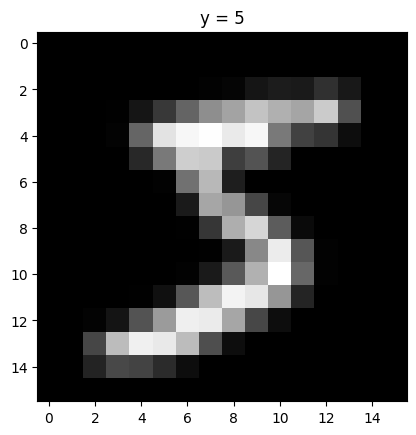

In [11]:
# The image for the first data sample
show_data(train_dataset[0])

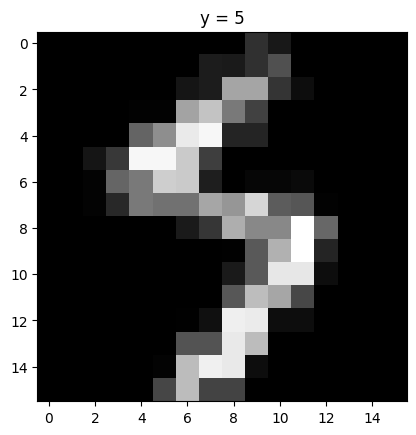

In [12]:
show_data(train_dataset_rotate[0])

In [13]:
class CNN(nn.Module):

  def __init__(self, out_1=16, out_2=32):
    super(CNN, self).__init__()

    # Channel Width after this layer is 16
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2) #(W_in - K + 2P) / S + 1 -- (16-5+2*2)/1+1=16
    self.maxpool1=nn.MaxPool2d(kernel_size=2) # 16/2 = 8
    # Channel Width after this layer is 8
    self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2) # (8-5+2*2)/1+1=8
    self.maxpool2=nn.MaxPool2d(kernel_size=2) # 8/2 = 4
    # In total we have out_2 (32) channels which are each 4 * 4 in size based on the width calculation above. Channels are squares.
    # flatten 32*4*4
    self.fc1 = nn.Linear(out_2 * 4 * 4, 10)

  def forward(self,x):
    x = self.cnn1(x)
    x = torch.relu(x)
    x = self.maxpool1(x)
    x = self.cnn2(x)
    x = torch.relu(x)
    x = self.maxpool2(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    return x


  def activations(self, x):
    # Outputs result of each stage of the CNN, relu, and pooling layers
    z1 = self.cnn1(x)
    a1 = torch.relu(z1)
    out = self.maxpool1(a1)
    z2 = self.cnn2(out)
    a2 = torch.relu(z2)
    out1 = self.maxpool2(a2)
    out = out.view(out.size(0),-1)
    return z1, a1, z2, a2, out1,out


In [38]:
# Create the model object to be trained on regular data using CNN class
model = CNN(out_1=16, out_2=32)

In [39]:
# We create a criterion which will measure loss
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
# Create an optimizer that updates model parameters using the learning rate and gradient
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
# Create a Data Loader for the training data with a batch size of 100 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
# Create a Data Loader for the rotated validation data with a batch size of 5000 
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [40]:
# Location to save data
file_normal = os.path.join(os.getcwd(), 'normal.pt')

# All the data we are saving
checkpoint={
            # Saving the number of epochs the models was trained for
            'epoch': None,
            # Saving the models parameters which will allow us to recreate the trained model
            'model_state_dict': None,
            # Saving the optimizers parameters
            'optimizer_state_dict': None,
            # Saving the loss on the training dataset for the last batch of the last epoch
            'loss': None,
            # Saving the cost on the training dataset for each epoch
            'cost': [],
            # Saving the accuracy for the testing dataset for each epoch
            'accuracy': []}

In [41]:
# Number of epochs to train model
n_epochs = 10

# Size of the testing dataset
N_test = len(validation_dataset)

# load the model to GPU
model.to(device)

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)

In [42]:
# optimize the model
for epoch in range(n_epochs):
    # Variable to keep track of cost for each epoch
    cost = 0
    # For each batch in the training dataset
    for x, y in train_loader:
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Makes a prediction on the image
        z = model(x.to(device))
        # Calculate the loss between the prediction and actual class
        loss = criterion(z, y.to(device))
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
      
        # Saves the number of epochs we trained for  
        checkpoint['epochs'] = n_epochs
        # Saves the models parameters
        checkpoint['model_state_dict'] = model.state_dict()
        # Saves the optimizers paramters
        checkpoint['optimizer_state_dict'] = optimizer.state_dict()
        # Saves the loss for the last batch so ultimately this will be the loss for the last batch of the last epoch
        checkpoint['loss'] = loss.cpu()
        # Accumulates the loss
        cost += loss.item()

        # Counter for the correct number of predictions        
        correct = 0
        
    # For each batch in the validation dataset
    for x_test, y_test in validation_loader:
      z = model(x_test.to(device))
      # Get the class that has the maximum value
      _, yhat = torch.max(z.data.cpu(), 1)
      # Counts the number of correct predictions made
      correct += (yhat == y_test).sum().item()
 
    accuracy = correct / N_test
    print(accuracy)
    # Appends the cost of the epoch to a list
    checkpoint['cost'].append(cost) 
    # Appends the accuracy of the epoch to a list
    checkpoint['accuracy'].append(accuracy)
    # Saves the data in checkpoint to the file location
    torch.save(checkpoint, file_normal) 

0.7524
0.7745
0.7911
0.7868
0.8017
0.7976
0.8041
0.8044
0.809
0.8073


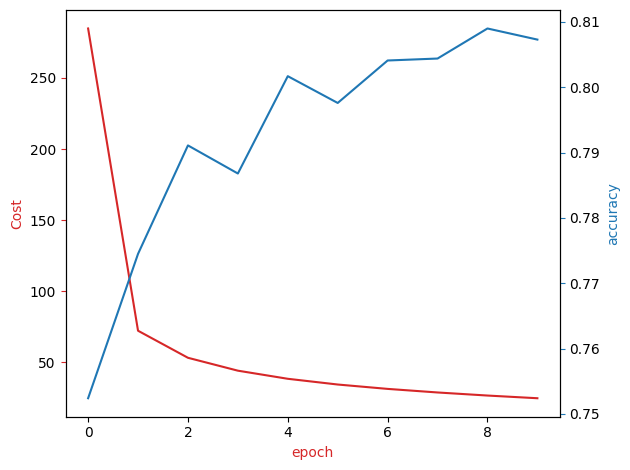

In [43]:
checkpoint_normal = torch.load(os.path.join(os.getcwd(),'normal.pt'))
# Using the helper function defined at the top and the cost and accuracy lists that we saved
plot_cost_accuracy(checkpoint_normal)

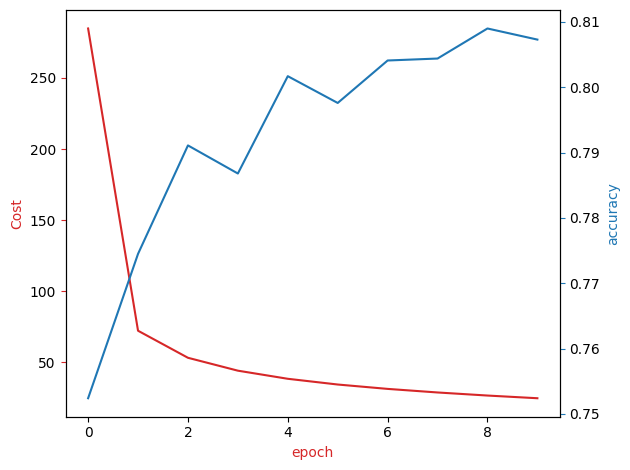

In [44]:
# Using the helper function defined at the top and the cost and accuracy lists that we saved
plot_cost_accuracy(checkpoint_normal)

In [45]:
# Create the model object using CNN class
model_r = CNN(out_1=16, out_2=32)
# We create a criterion which will measure loss
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
# Create an optimizer that updates model parameters using the learning rate and gradient
optimizer = torch.optim.SGD(model_r.parameters(), lr = learning_rate)
# Create a Data Loader for the rotated training data with a batch size of 100 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_rotate, batch_size=100)
# Create a Data Loader for the rotated validation data with a batch size of 5000 
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [46]:
# Location to save data
file_rotated = os.path.join(os.getcwd(), 'rotated_data.pt')

# All the data we are saving
checkpoint={
            # Saving the number of epochs the models was trained for
            'epoch': None,
            # Saving the models parameters which will allow us to recreate the trained model
            'model_state_dict': None,
            # Saving the optimizers parameters
            'optimizer_state_dict': None,
            # Saving the loss on the training dataset for the last batch of the last epoch
            'loss': None,
            # Saving the cost on the training dataset for each epoch
            'cost': [],
            # Saving the accuracy for the testing dataset for each epoch
            'accuracy': []}

In [47]:
# Number of epochs to train model            
n_epochs = 10

# Size of the testing dataset
N_test = len(validation_dataset)
model_r.to(device)

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)

In [48]:
# Training for the number of epochs we want
for epoch in range(n_epochs):
    # Variable to keep track of cost for each epoch
    cost = 0
    # For each batch in the training dataset
    for x, y in train_loader:
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Makes a prediction on the image
        z = model_r(x.to(device))
        # Calculate the loss between the prediction and actual class
        loss = criterion(z, y.to(device))
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
      
        # Saves the number of epochs we trained for  
        checkpoint['epochs'] = n_epochs
        # Saves the models parameters
        checkpoint['model_state_dict'] = model.state_dict()
        # Saves the optimizers paramters
        checkpoint['optimizer_state_dict'] = optimizer.state_dict()
        # Saves the loss for the last batch so ultimately this will be the loss for the last batch of the last epoch
        checkpoint['loss'] = loss
        # Accumulates the loss
        cost+=loss.item()
        
        # Counter for the correct number of predictions        
        correct = 0
        
        # For each batch in the validation dataset
    for x_test, y_test in validation_loader:
        # Make a prediction
        z = model_r(x_test.to(device))
        # Get the class that has the maximum value
        _, yhat = torch.max(z.data.cpu(), 1)
        # Counts the number of correct predictions made
        correct += (yhat == y_test).sum().item()
 
    accuracy = correct / N_test
    print(accuracy)
    # Appends the cost of the epoch to a list
    checkpoint['cost'].append(cost) 
    # Appends the accuracy of the epoch to a list
    checkpoint['accuracy'].append(accuracy)
    # Saves the data in checkpoint to the file location
    torch.save(checkpoint, file_rotated) 

0.9039
0.9346
0.9401
0.9486
0.9513
0.9588
0.9598
0.9595
0.9657
0.9633


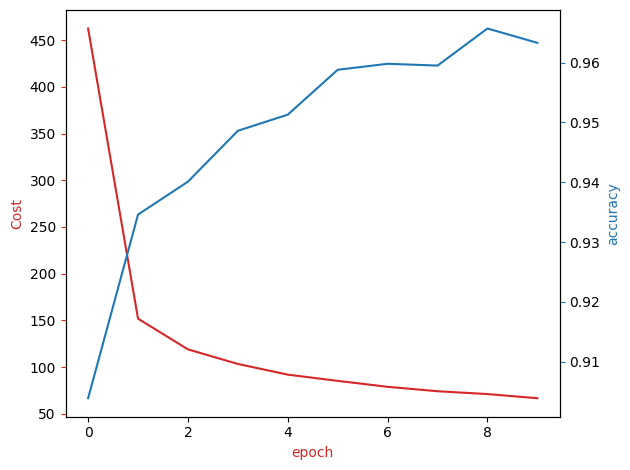

In [49]:
checkpoint_rotated= torch.load(os.path.join(os.getcwd(),'rotated_data.pt'))
# Using the helper function defined at the top and the cost and accuracy lists that we saved
plot_cost_accuracy(checkpoint_rotated)

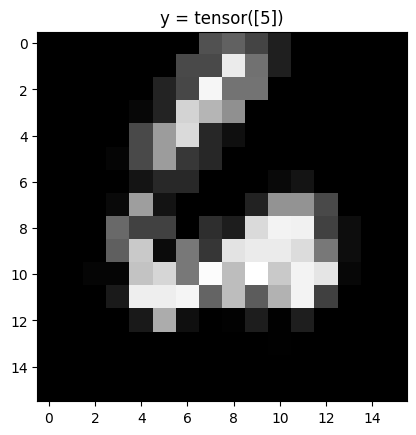

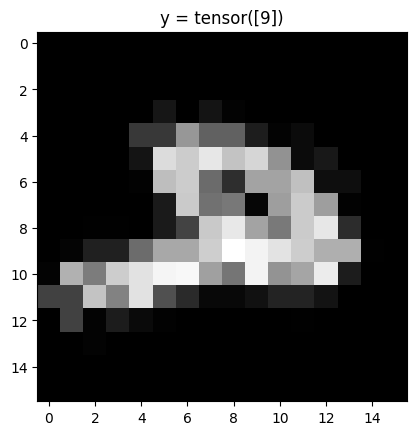

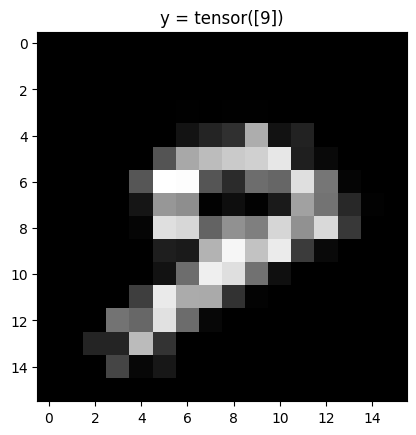

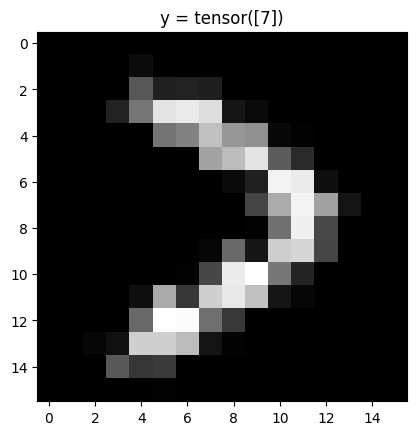

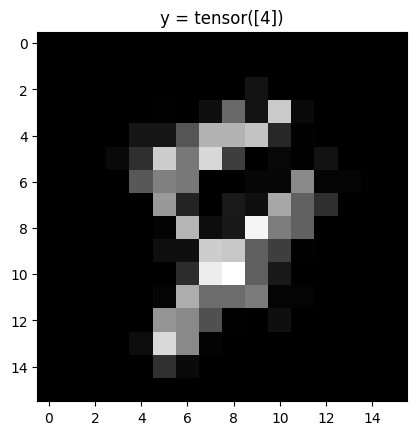

In [50]:
# Using the model parameters we saved we load them into a model to recreate the trained model
model_r.load_state_dict(checkpoint_rotated['model_state_dict'])
# Setting the model to evaluation mode
model.eval()
# Using the helper function plot the first five misclassified samples
plot_mis_classified(model_r.cpu(),validation_dataset)